In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils import data

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [3]:
df

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RMED,RDEP,RHOB,GR,NPHI,PEF,DTC,BS,ROP,DTS,DCAL,DRHO,ROPA,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,1518.2800,433906.7500,6460000.5,-1493.241821,15.506232,1.461974,0.878615,2.345301,103.451515,0.439925,5.820852,147.043427,17.5,146.526276,326.451263,-1.993768,0.109706,88.968864,65000.0,3.0
1,1518.4320,433906.7500,6460000.5,-1493.393799,18.524611,1.461974,0.874237,2.345301,94.124893,0.504055,5.820852,145.426468,17.5,147.605148,322.926361,1.024611,-0.006418,92.287186,65000.0,3.0
2,1518.5840,433906.7500,6460000.5,-1493.545776,18.855669,1.461974,0.869858,2.345301,93.586487,0.512960,5.820852,145.295105,17.5,140.783127,325.283142,1.355668,0.022769,95.605499,65000.0,3.0
3,1518.7360,433906.7500,6460000.5,-1493.697754,19.163353,1.461974,0.865479,2.345301,91.113373,0.500070,5.820852,143.657593,17.5,125.159531,334.233185,1.663353,0.024972,98.923820,65000.0,3.0
4,1518.8880,433906.7500,6460000.5,-1493.849609,18.489744,0.849849,0.863804,2.345301,100.228333,0.277670,5.820852,142.838440,17.5,107.576691,330.952362,0.989743,0.024527,102.242142,65000.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121419,2973.2988,536096.0625,6793022.0,-2943.444580,8.276272,2.820439,3.158570,2.373673,90.720284,0.156916,3.806974,75.260658,8.5,15.195305,136.911575,0.240471,0.502458,24.306124,65000.0,2.0
121420,2973.4508,536096.0625,6793022.0,-2943.595947,8.267273,3.020778,3.332977,2.373673,87.062027,0.156916,3.806974,74.868301,8.5,15.770223,137.583923,0.240471,0.374753,22.201078,65000.0,2.0
121421,2973.6028,536096.0625,6793022.0,-2943.747559,8.250099,2.795711,3.044179,2.373673,86.115921,0.156916,3.806974,74.848122,8.5,16.418465,138.310898,0.240471,0.211487,20.096741,65000.0,2.0
121422,2973.7548,536096.0625,6793022.0,-2943.899170,8.250099,2.658694,2.847681,2.373673,89.497131,0.156916,3.806974,74.964027,8.5,17.037945,137.592819,0.240471,0.147950,17.992323,65000.0,2.0


In [4]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [5]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [6]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [7]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [8]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [9]:
from sklearn.model_selection import train_test_split

train_, val = train_test_split(df, test_size=0.2, random_state=42,
                               shuffle=True, stratify=df.FORCE_2020_LITHOFACIES_LITHOLOGY)

In [10]:
train = CustomDataset(dataframe=train_, feature_names=feature_names, target_name=target_name)
val = CustomDataset(dataframe=val, feature_names=feature_names, target_name=target_name)

train, test = data.random_split(train, [0.8, 0.2])

In [11]:
train_data = DataLoader(dataset=train, batch_size=20, shuffle=True)
val_data = DataLoader(dataset=val, batch_size=20, shuffle=True)
test_data = DataLoader(dataset=test, batch_size=20, shuffle=False)

In [12]:
len(feature_names)

18

In [13]:
model = nn.Sequential(
    nn.Conv1d(1, 64, len(feature_names), padding=3),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Conv1d(64, 64, 5, padding=3),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Conv1d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Conv1d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.Conv1d(128, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Conv1d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm1d(64),

    nn.Flatten(),
    nn.Linear(576, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, len(target_name))
)

In [14]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001, ) # weight_decay=0.001
loss_function = nn.CrossEntropyLoss()

In [15]:
model.train()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(18,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(3,))
  (4): ReLU()
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (10): ReLU()
  (11): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (12): ReLU()
  (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (15): ReLU()
  (16): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in

In [16]:
epochs = 100
best_loss = 1e10 # заведомо высокое значение
loss_val = []
loss_train = []

for e in range(epochs):
    model.train()
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=False)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')
    
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in val_data:
        with torch.no_grad():
            prediction = model(x_val)
            loss = loss_function(prediction, y_val)
            Q_val += loss.item()
            count_val += 1

    Q_val /= count_val

    loss_train.append(loss_mean)
    loss_val.append(Q_val)
    
    print(f' | loss_mean={loss_mean:.3f}, Q_val={Q_val:.3f}')

  0%|          | 0/3886 [00:00<?, ?it/s]

 | loss_mean=0.491, Q_val=0.344


 | loss_mean=0.349, Q_val=0.315


 | loss_mean=0.310, Q_val=0.310


 | loss_mean=0.286, Q_val=0.281


 | loss_mean=0.271, Q_val=0.258


 | loss_mean=0.257, Q_val=0.243


 | loss_mean=0.246, Q_val=0.250


 | loss_mean=0.236, Q_val=0.249


 | loss_mean=0.230, Q_val=0.288


 | loss_mean=0.227, Q_val=0.225


 | loss_mean=0.218, Q_val=0.274


 | loss_mean=0.214, Q_val=0.225


 | loss_mean=0.208, Q_val=0.218


 | loss_mean=0.204, Q_val=0.225


 | loss_mean=0.200, Q_val=0.225


 | loss_mean=0.196, Q_val=0.251


 | loss_mean=0.192, Q_val=0.241


 | loss_mean=0.187, Q_val=0.216


 | loss_mean=0.185, Q_val=0.216


 | loss_mean=0.182, Q_val=0.210


 | loss_mean=0.178, Q_val=0.210


 | loss_mean=0.177, Q_val=0.209


 | loss_mean=0.173, Q_val=0.221


 | loss_mean=0.172, Q_val=0.214


 | loss_mean=0.169, Q_val=0.205


 | loss_mean=0.165, Q_val=0.201


 | loss_mean=0.165, Q_val=0.201


 | loss_mean=0.164, Q_val=0.209


 | loss_mean=0.159, Q_val=0.200


 | loss_mean=0.156, Q_val=0.206


 | loss_mean=0.155, Q_val=0.208


 | loss_mean=0.154, Q_val=0.203


 | loss_mean=0.152, Q_val=0.208


 | loss_mean=0.153, Q_val=0.208


 | loss_mean=0.149, Q_val=0.198


 | loss_mean=0.148, Q_val=0.203


 | loss_mean=0.147, Q_val=0.203


 | loss_mean=0.144, Q_val=0.209


 | loss_mean=0.143, Q_val=0.195


 | loss_mean=0.147, Q_val=0.198


 | loss_mean=0.143, Q_val=0.204


 | loss_mean=0.139, Q_val=0.217


 | loss_mean=0.139, Q_val=0.192


 | loss_mean=0.138, Q_val=0.206


 | loss_mean=0.136, Q_val=0.189


 | loss_mean=0.137, Q_val=0.198


 | loss_mean=0.133, Q_val=0.236


 | loss_mean=0.134, Q_val=0.267


 | loss_mean=0.132, Q_val=0.209


 | loss_mean=0.131, Q_val=0.210


 | loss_mean=0.131, Q_val=0.209


 | loss_mean=0.128, Q_val=0.192


 | loss_mean=0.128, Q_val=0.203


 | loss_mean=0.127, Q_val=0.206


 | loss_mean=0.127, Q_val=0.193


 | loss_mean=0.126, Q_val=0.190


 | loss_mean=0.123, Q_val=0.202


 | loss_mean=0.121, Q_val=0.237


 | loss_mean=0.122, Q_val=0.204


 | loss_mean=0.123, Q_val=0.202


 | loss_mean=0.119, Q_val=0.212


 | loss_mean=0.121, Q_val=0.211


 | loss_mean=0.116, Q_val=0.200


 | loss_mean=0.117, Q_val=0.235


 | loss_mean=0.117, Q_val=0.208


 | loss_mean=0.115, Q_val=0.216


 | loss_mean=0.115, Q_val=0.202


 | loss_mean=0.115, Q_val=0.200


 | loss_mean=0.111, Q_val=0.210


 | loss_mean=0.113, Q_val=0.202


 | loss_mean=0.114, Q_val=0.202


 | loss_mean=0.112, Q_val=0.208


 | loss_mean=0.112, Q_val=0.210


 | loss_mean=0.109, Q_val=0.206


 | loss_mean=0.110, Q_val=0.205


 | loss_mean=0.108, Q_val=0.212


 | loss_mean=0.107, Q_val=0.204


 | loss_mean=0.107, Q_val=0.207


 | loss_mean=0.106, Q_val=0.218


 | loss_mean=0.106, Q_val=0.206


 | loss_mean=0.105, Q_val=0.198


 | loss_mean=0.106, Q_val=0.205


 | loss_mean=0.104, Q_val=0.207


 | loss_mean=0.105, Q_val=0.223


 | loss_mean=0.103, Q_val=0.258


 | loss_mean=0.101, Q_val=0.216


 | loss_mean=0.102, Q_val=0.230


 | loss_mean=0.100, Q_val=0.228


 | loss_mean=0.100, Q_val=0.218


 | loss_mean=0.101, Q_val=0.221


 | loss_mean=0.099, Q_val=0.215


 | loss_mean=0.099, Q_val=0.213


 | loss_mean=0.102, Q_val=0.208


 | loss_mean=0.097, Q_val=0.209


 | loss_mean=0.099, Q_val=0.214


 | loss_mean=0.100, Q_val=0.247


 | loss_mean=0.099, Q_val=0.210


 | loss_mean=0.096, Q_val=0.300


 | loss_mean=0.100, Q_val=0.218


 | loss_mean=0.100, Q_val=0.214


In [17]:
Q = 0

In [18]:
model.eval()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(18,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(3,))
  (4): ReLU()
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (10): ReLU()
  (11): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (12): ReLU()
  (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (15): ReLU()
  (16): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in

In [19]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

100%|██████████| 972/972 [00:09<00:00, 103.08it/s]


In [20]:
Q /= len(test_data)
print(Q)

18.814814814814813


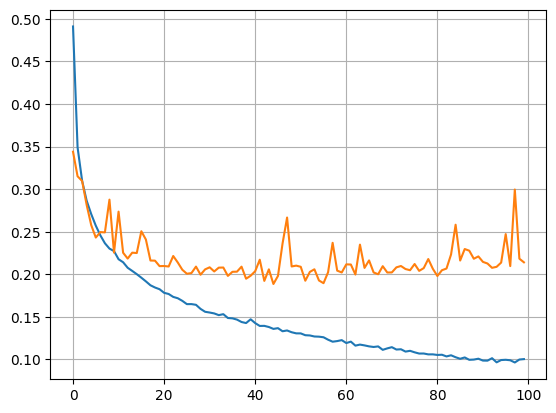

In [21]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2299
           1       0.85      0.85      0.85      1731
           2       0.97      0.97      0.97     11099
           3       0.89      0.91      0.90       874
           4       0.57      0.50      0.53        32
           5       0.90      0.83      0.86      1370
           6       0.97      0.98      0.98       456
           7       0.99      1.00      0.99      1060
           8       0.89      0.74      0.80        95
           9       0.93      0.95      0.94       379
          10       0.74      0.88      0.80        32

    accuracy                           0.94     19427
   macro avg       0.87      0.87      0.87     19427
weighted avg       0.94      0.94      0.94     19427



<Axes: >

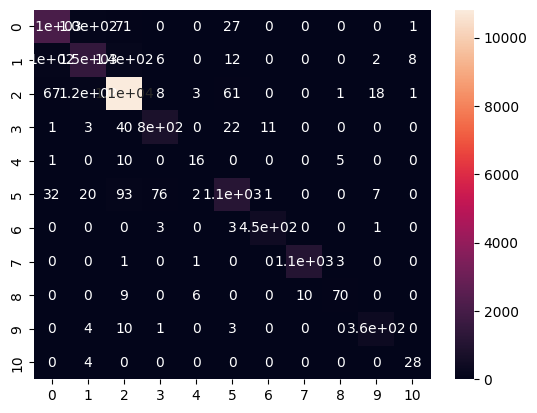

In [24]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [25]:
st = model.state_dict()
torch.save(st, 'models/conv_model_1.tar')

In [26]:
model.eval()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(18,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(3,))
  (4): ReLU()
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (10): ReLU()
  (11): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (12): ReLU()
  (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (15): ReLU()
  (16): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in

In [27]:
Q = 0
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

  0%|          | 0/972 [00:00<?, ?it/s]

100%|██████████| 972/972 [00:08<00:00, 119.48it/s]


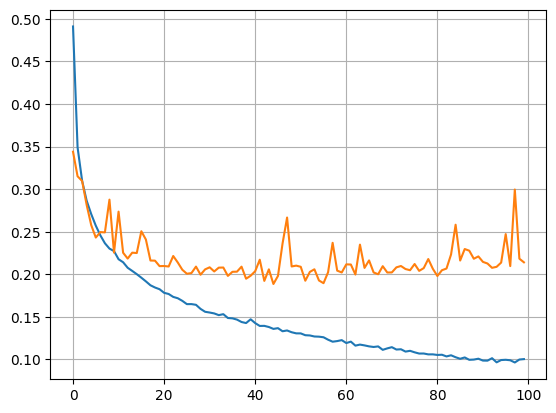

In [28]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.grid()
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2299
           1       0.85      0.85      0.85      1731
           2       0.97      0.97      0.97     11099
           3       0.89      0.91      0.90       874
           4       0.57      0.50      0.53        32
           5       0.90      0.83      0.86      1370
           6       0.97      0.98      0.98       456
           7       0.99      1.00      0.99      1060
           8       0.89      0.74      0.80        95
           9       0.93      0.95      0.94       379
          10       0.74      0.88      0.80        32

    accuracy                           0.94     19427
   macro avg       0.87      0.87      0.87     19427
weighted avg       0.94      0.94      0.94     19427



<Axes: >

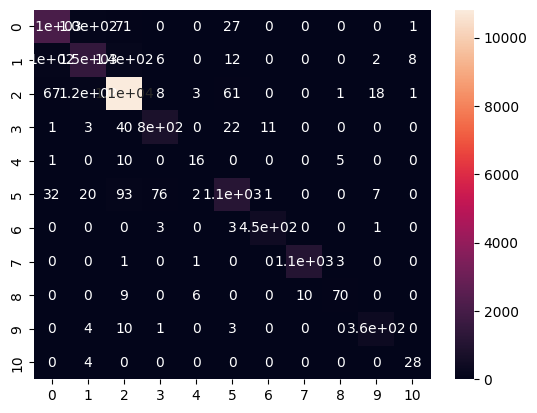

In [31]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [32]:
class ConvNet(nn.Module):
    def __init__(self, n_class, in_channels):
        super().__init__()

        self.conv_1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=2, padding=1)
        self.conv_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2, padding=1)
